In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv("bbc-text.csv")

In [3]:
data['category_id'] = data['category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
data['category_id'][0:10]

0    0
1    1
2    2
3    2
4    3
5    4
6    4
7    2
8    2
9    3
Name: category_id, dtype: int32

In [4]:
data.head()

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


In [5]:
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


In [7]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [8]:
category_to_id

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}

In [9]:
data.groupby('category').category_id.count()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

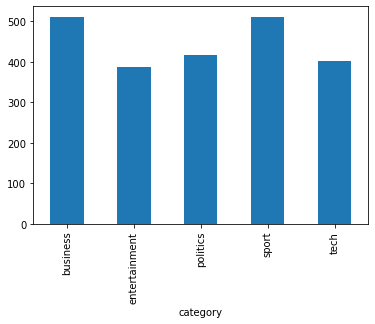

In [10]:
data.groupby('category').category_id.count().plot.bar(ylim=0)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = data.category_id    

In [17]:
features.shape

(2225, 14415)

In [20]:
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) 
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


Text(0.5, 15.0, 'Predicted')

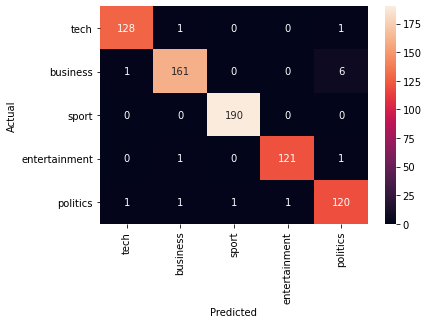

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [26]:
model.fit(features, labels)

LogisticRegression(random_state=0)

In [30]:
texts = ["Entrepreneurs and business owners have a certain kind of spirit and drive that keeps pushing them forward. Use this business article to find out if you possess the qualities of an entrepreneur yourself.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "three days in Houston interviewing for the Rockets’ coaching vacancy."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Entrepreneurs and business owners have a certain kind of spirit and drive that keeps pushing them forward. Use this business article to find out if you possess the qualities of an entrepreneur yourself."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"three days in Houston interviewing for the Rockets’ coaching vacancy."
  - Predicted as: 'sport'

